In [2]:
# Import external tools:
import time 
import random
from matplotlib import pyplot as plt
import librosa
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import torchaudio
import soundfile as sf
from scipy import signal
import getpass
import pandas as pd
import numpy as np
import sys
import os
import importlib
from scipy.io import wavfile
from IPython.display import Audio
from datetime import datetime
from sklearn.manifold import TSNE


projectdir="/home/ubuntu/joanna/VAE-IR/"
datadir="/home/ubuntu/Data/"

# Add path of this project
sys.path.insert(0, projectdir+'src/')

# # Import and automatically reload my own modules:
import sig2ir_datasetprep as dsprep;importlib.reload(dsprep)
import helpers; importlib.reload(helpers)

<module 'helpers' from '/home/ubuntu/joanna/VAE-IR/src/helpers.py'>

In [3]:
# Create a data frame containing a list of all available audio files (will be used as audio pool in the dataset generation)
audiodatadir=datadir + "VCTK/wav48_silence_trimmed/"
filename="audio_VCTK_datura.csv"

import os
file_paths = []

# Traverse the directory and find all .flac files in subdirectories
for root, dirs, files in os.walk(audiodatadir):
    for file in files:
        if file.endswith('.flac'):
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

# Create a DataFrame using the file_paths list
df_audio = pd.DataFrame({'filepath_sig': file_paths})
df_audio.loc[df_audio["filepath_sig"].str.contains("VCTK"),"database_sig"]="vctk"

df_audio.loc[df_audio["filepath_sig"].str.contains("mic1"),"mic"]=1
df_audio.loc[df_audio["filepath_sig"].str.contains("mic2"),"mic"]=2

df_audio.to_csv("../"+filename)

In [4]:
# Do some small changes in the dataframe storing impulse responses 
df_ir = pd.read_csv("../irstats_ARNIandBUT_datura.csv",index_col=0)
df_ir = df_ir.rename(columns={'filepath': 'filepath_ir'})
df_ir.loc[df_ir["filepath_ir"].str.contains("Arni"),"database_ir"]="arni"
df_ir.loc[df_ir["filepath_ir"].str.contains("BUT"),"database_ir"]="but"

# TODO : Add synthetic IRs

df_ir.to_csv("../irstats_ARNIandBUT_datura.csv")
df_ir.head(10)

,filepath_ir,rt,drr,cte,edt,database_ir
0,/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5...,1.881882,-3.240771,18.945984,0.080952,arni
1,/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5...,1.794751,-3.240398,18.948890,0.081020,arni
2,/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5...,1.870272,-3.244588,18.956458,0.081020,arni
3,/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5...,1.799626,-3.246946,18.951266,0.081088,arni
4,/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5...,2.193537,-5.083123,19.252165,0.108912,arni
5,/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5...,2.042925,-5.085210,19.249037,0.108776,arni
6,/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5...,2.117120,-5.083805,19.258418,0.108844,arni
7,/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5...,2.091769,-5.093821,19.242977,0.108776,arni
8,/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5...,2.014819,-2.197278,19.789352,0.074694,arni
9,/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5...,1.991678,-2.199771,19.804730,0.074694,arni


In [5]:
# Set random seed for NumPy, Pandas, and PyTorch
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# set up sources of RIRs and audios for dataset
AUDIO_INFO_FILE = "/home/ubuntu/joanna/VAE-IR/audio_VCTK_datura.csv"
IR_INFO_FILE = "/home/ubuntu/joanna/VAE-IR/irstats_ARNIandBUT_datura.csv"
SAMPLING_RATE=48e3

df_audiopool=pd.read_csv(AUDIO_INFO_FILE,index_col=0)
df_irs=pd.read_csv(IR_INFO_FILE,index_col=0)
df_irs=df_irs[df_irs["database_ir"]=="arni"]
df_irs=df_irs.head(10)

dataset=dsprep.Dataset_SpeechInSpace(df_audiopool,df_irs,sr=SAMPLING_RATE, ir_len=SAMPLING_RATE*2, 
                                  sig_len=int(SAMPLING_RATE*2.73), N_per_ir=1e4)

# # create a tag for dataset info file
# current_datetime = datetime.now()
# nametag = current_datetime.strftime("%d-%m-%Y_%H-%M")
# # save info about dataset
# dataset.dataset_info(nametag)


/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5/IR_numClosed_0_numComb_1_mic_1_sweep_1.wav
sig.shape=torch.Size([1, 131040])
ir.shape=torch.Size([1, 96000])
dp.shape=torch.Size([1, 1, 131040])


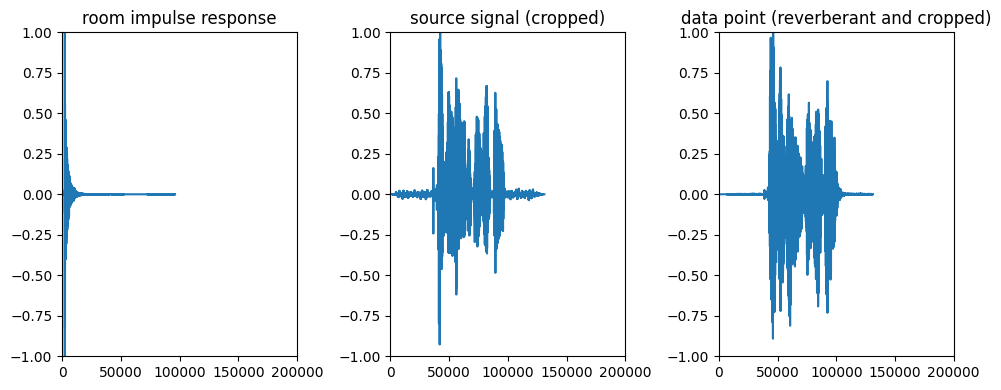

In [13]:
# Inspect a data point: 

sig, ir, dp, label=dataset[1]
print(label["filepath_ir"])
print(f"{sig.shape=}")
print(f"{ir.shape=}")
print(f"{dp.shape=}")

fig = plt.figure(figsize=(10, 4))
plt.subplot(1,3,1)
plt.plot(ir.T)
plt.xlim((0,200000))
plt.ylim((-1,1))
plt.title('room impulse response')

plt.subplot(1,3,2)
plt.plot(sig.T)
plt.xlim((0,200000))
plt.ylim((-1,1))
plt.title('source signal (cropped)')

plt.subplot(1,3,3)
plt.plot(dp.squeeze([0]).T)
plt.xlim((0,200000))
plt.ylim((-1,1))
plt.title('data point (reverberant and cropped)')
plt.tight_layout()
plt.show()






In [7]:
# PLAYBACK: ROOM IMPULSE RESPONSE
print(label["filepath_ir"])
Audio(ir,rate=48000)


/home/ubuntu/Data/IR_Arni_upload_numClosed_0-5/IR_numClosed_0_numComb_1_mic_1_sweep_1.wav


In [8]:
# PLAYBACK: EXCERPT FROM SPEECH DATABASE
print(label["filepath_sig"])
Audio(sig,rate=48000)


/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p261/p261_171_mic2.flac


In [9]:
# PLAYBACK: REVERBERANT SIGNAL 
Audio(dp.squeeze([0]),rate=48000)